# HPF data quickstart

The Habitable-Zone Planet Finder (HPF) spectrograph provides its data in 28 chunks called echelle orders.  In this notebook, we will read in the data with `astropy`, convert it to a `pandas` dataframe, and then plot it.  This data is in its original format and still posesses instrumental signals.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
%matplotlib inline
%config InlineBackend.figure_format='retina'

HPF raw data gets processed with two different data reduction pipelines: *Goldilocks* and the default facility data reduction from the Penn State Instrument Team.  These two reductions have slightly different precisions, but for our purposes are essentially indistinguishable.  However, the data columns have different names, so they have to be handled differently.

In [2]:
goldilocks_files = glob.glob('../data/HPF/Helium-transit-data/**/Goldilocks*.fits', recursive=True)
pennstate_files = glob.glob('../data/HPF/Helium-transit-data/**/Slope*.fits', recursive=True)

In [3]:
len(goldilocks_files), len(pennstate_files)

(410, 593)

Let's pick a random Goldilocks file to read it in:

In [4]:
index = np.random.randint(0, 410)
fn = goldilocks_files[index]

In [5]:
from astropy.io import fits

In [6]:
hdus = fits.open(fn)
hdus.info()

Filename: ../data/HPF/Helium-transit-data\HAT-P-32b\in-transit\20200919\Goldilocks_20200919T061054_v1.0_0022.spectra.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     317   ()      
  1  Sci Flux      1 ImageHDU         8   (2048, 28)   float32   
  2  Sky Flux      1 ImageHDU         8   (2048, 28)   float32   
  3  Cal Flux      1 ImageHDU         8   (2048, 28)   float32   
  4  Sci Error     1 ImageHDU         8   (2048, 28)   float32   
  5  Sky Error     1 ImageHDU         8   (2048, 28)   float32   
  6  Cal Error     1 ImageHDU         8   (2048, 28)   float32   
  7  Sci Wavl      1 ImageHDU         8   (2048, 28)   float64   
  8  Sky Wavl      1 ImageHDU         8   (2048, 28)   float64   
  9  Cal Wavl      1 ImageHDU         8   (2048, 28)   float64   


HPF data contains trios of ($\lambda$, flux, error) for the science target-of-interest, `Sci`, the background sky, `Sky`, and (optionally) a laser frequency comb, `Cal`.

Let's read the original fits file into a `pandas` DataFrame.

In [7]:
df_original = pd.DataFrame()

In [8]:
for j in range(28):
    df = pd.DataFrame()
    for i in range(1, 10):
        name = hdus[i].name
        df[name] = hdus[i].data[j, :]
    df['order'] = j
    df_original = df_original.append(df, ignore_index=True)

In [9]:
df_original.head()

,Sci Flux,Sky Flux,Cal Flux,Sci Error,Sky Error,Cal Error,Sci Wavl,Sky Wavl,Cal Wavl,order
0,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,8079.036346,8079.040520,8079.025668,0
1,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,8079.095831,8079.100003,8079.085160,0
2,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,8079.155310,8079.159478,8079.144645,0
3,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,8079.214781,8079.218946,8079.204122,0
4,2.283742,-0.018036,0.050206,0.0612,0.017639,0.020712,8079.274245,8079.278406,8079.263591,0


In [10]:
df_original.shape

(57344, 10)

There are ~57,000 unique data points in a single HPF spectrum.  Some of the rows have the first six columns empty (`=0.0`), let's drop those.

In [11]:
keep_mask = df_original[df_original.columns[0:6]] != 0.0

In [12]:
df_original = df_original[keep_mask.all(axis=1)]

In [13]:
df_original.head()

,Sci Flux,Sky Flux,Cal Flux,Sci Error,Sky Error,Cal Error,Sci Wavl,Sky Wavl,Cal Wavl,order
4,2.283742,-0.018036,0.050206,0.061200,0.017639,0.020712,8079.274245,8079.278406,8079.263591,0
5,2.343015,-0.008722,0.028707,0.061710,0.018573,0.020395,8079.333701,8079.337859,8079.323054,0
6,2.154527,-0.056950,-0.015929,0.059333,0.016783,0.018277,8079.393149,8079.397304,8079.382508,0
7,2.155278,-0.031793,-0.005561,0.059435,0.017534,0.018710,8079.452590,8079.456742,8079.441956,0
8,2.187173,-0.010079,0.036203,0.059745,0.018644,0.020423,8079.512024,8079.516172,8079.501395,0


Let's make an extra-wide plot of all the echelle orders.

In [14]:
import seaborn as sns

In [15]:
sns.set_context('talk')

In [16]:
sns.set_palette("Reds", n_colors=28)

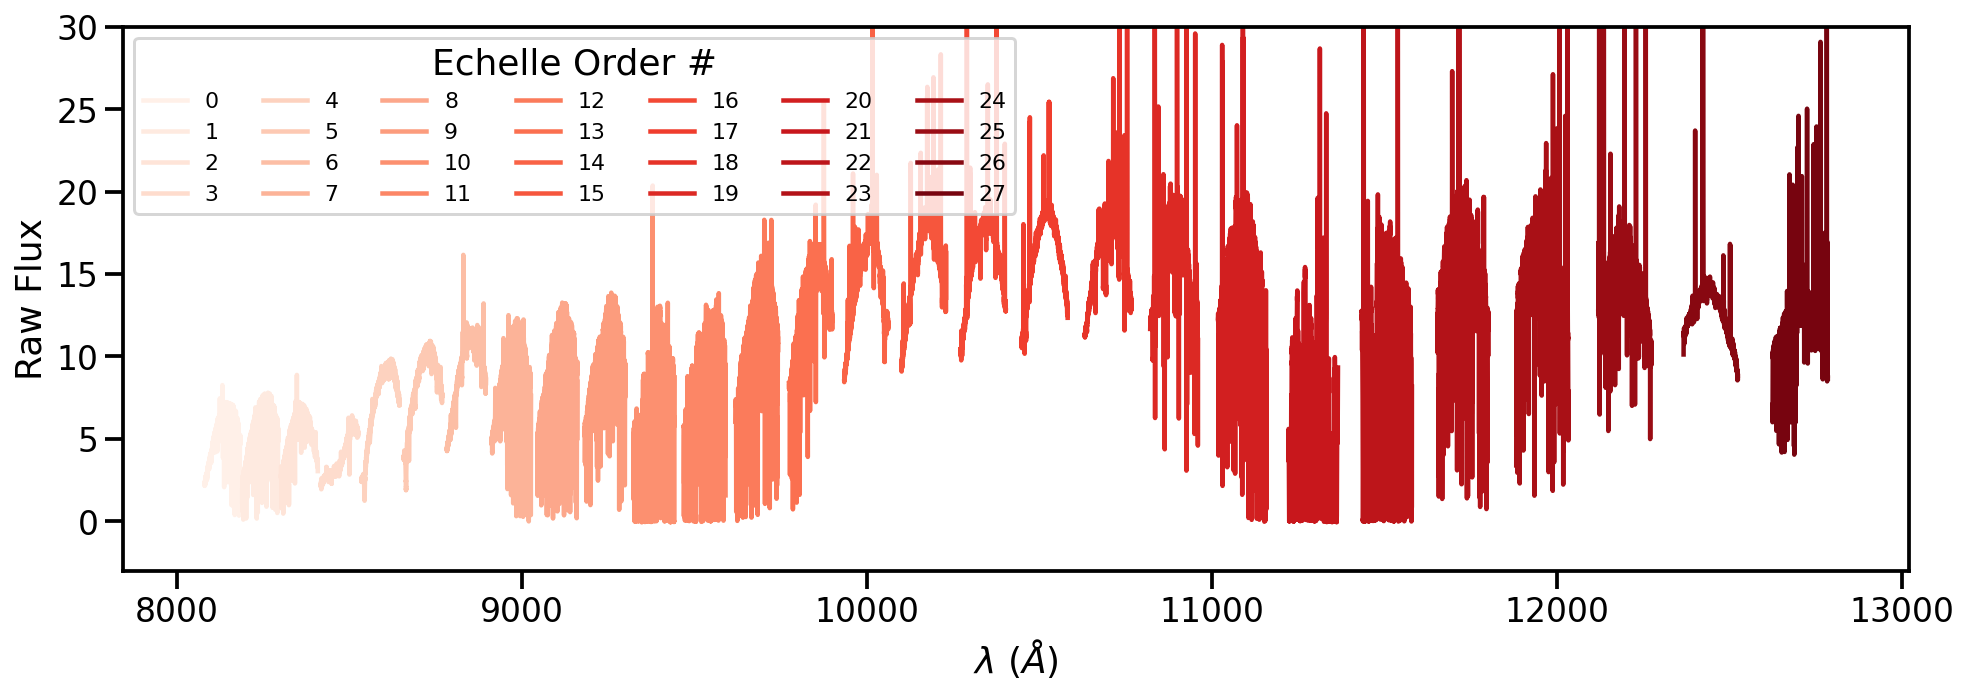

In [17]:
plt.figure(figsize=(16, 5))
for order, group in df_original.groupby('order'):
    plt.plot(group['Sci Wavl'], group['Sci Flux'], label=order);
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.ylim(-3, 30)
plt.legend(ncol=7, title='Echelle Order #', fontsize=11);

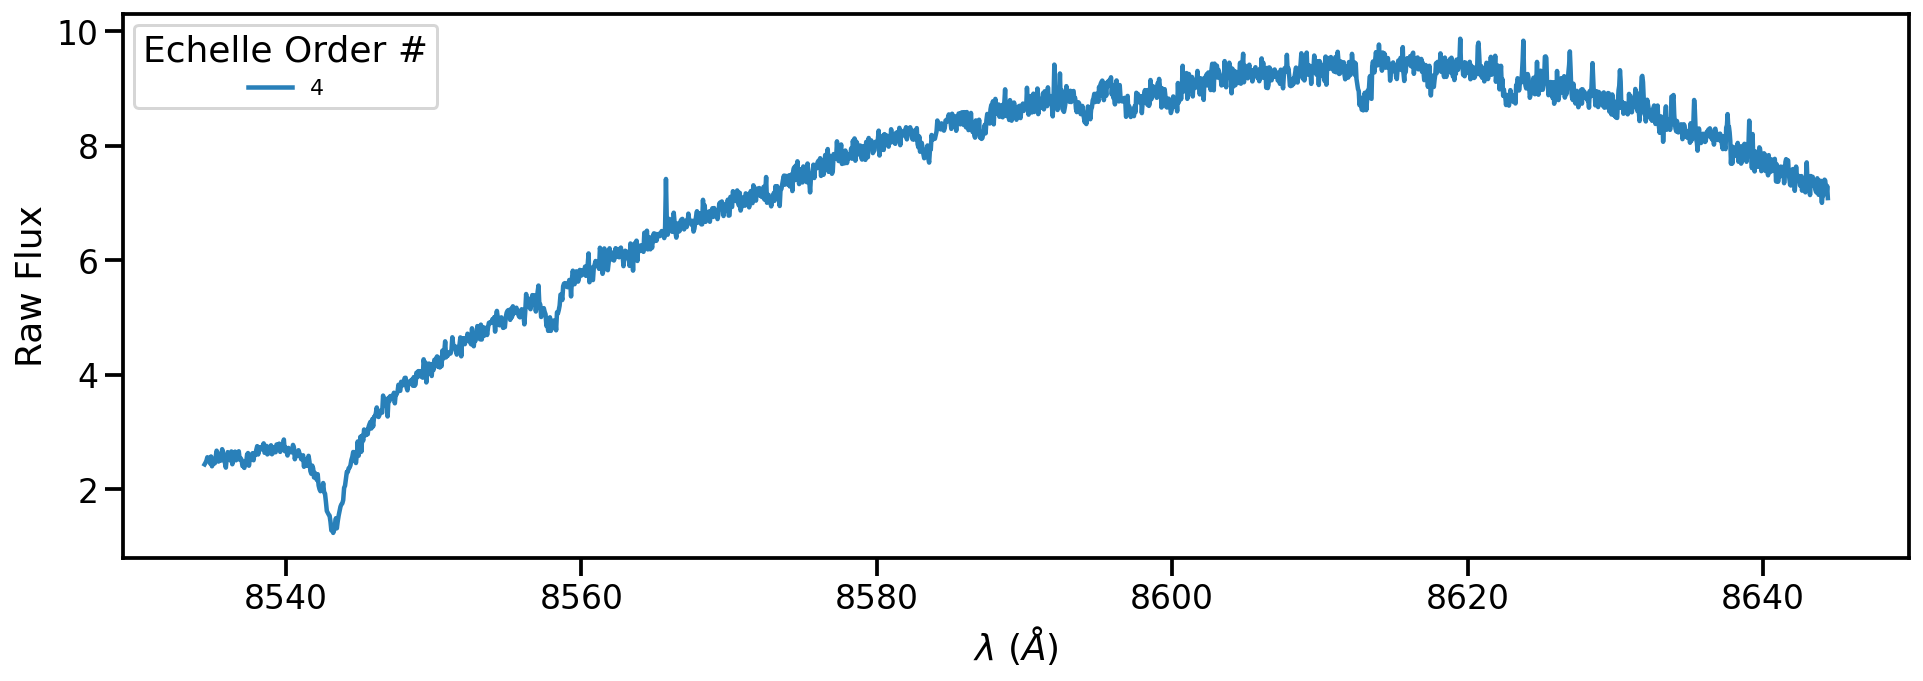

In [18]:
plt.figure(figsize=(16, 5))
order = 4
mask = df_original.order == order
plt.plot(df_original['Sci Wavl'][mask], df_original['Sci Flux'][mask], label=order, color='#2980b9');
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.legend(ncol=7, title='Echelle Order #', fontsize=11);

Neat, we see each echelle order forms an inverted-U shape called the *blaze envelope*, arising from the characteristic relative efficiency of the spectrograph.  The large upward spikes are sky emission lines, and the cluster of lines that aproach zero are *telluric absorption lines*.  The next step is to post-process the original spectrum to mitigate these instrumental signals.  